### Notebook to develop threshold for modified NDSI (MNDSI) for identifying snow in PlanetScope 4-band imagery
Rainey Aberle

December 2021

### Import packages

In [1]:
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry.polygon import Polygon
import earthpy.spatial as es
import scipy
import matplotlib.pyplot as plt
import matplotlib
import itertools
from xml.dom import minidom

### Define paths to directories

In [2]:
# base directory
basepath = '/Users/raineyaberle/Research/PhD/Wolverine/'
# image directory
impath = basepath+'imagery/Planet/2021-04-20_2021-08-25/SR-stitched/'
# output folder
outpath = basepath+'imagery/Planet/2021-04-20_2021-08-25/SCA/'

### Define Area of Interest (AOI)
#### Read in a shapefile with AOI polygon

In [3]:
# Load shapefile
fn = basepath+'GIS_data/wolverine_RGI.shp'
AOI = gpd.read_file(fn)
print('Original shapefile CRS:',AOI.crs)

# Reproject to imagery CRS if necessary
AOI = AOI.to_crs(32606)

# print information
print('Reprojected shapefile CRS: ',AOI.crs)
print('Shapefile bounds:',AOI.boundary)

Original shapefile CRS: epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTILINESTRING ((393342.531 6698475.452, 3933...
dtype: geometry


### Load image and shapefiles for tuning threshold: digitized snow line & transects

In [23]:
# image
os.chdir(impath) # change directory
im_name = glob.glob('20210821.tif')
print('Image: ',im_name[0])
print('')

# snowline
sl_fn = basepath+'GIS_data/digitized_snowline_picks/20210821_snowline.shp'
sl = gpd.read_file(sl_fn) # snowline
print('Snowline')
print('CRS: ',sl.crs)
# Reproject to imagery CRS if necessary
sl = sl.to_crs(32606)
# print information
print('Reprojected shapefile CRS: ',sl.crs)
print('Shapefile bounds:',sl.boundary)
print('')

# transect 
ts_fn = basepath+'GIS_data/digitized_snowline_picks/transect.shp'
ts = gpd.read_file(ts_fn) # snowline
print('Transect')
print('CRS:',ts.crs)
# Reproject to imagery CRS if necessary
ts = ts.to_crs(32606)
# print information
print('Reprojected CRS: ',ts.crs)
print('Bounds:',ts.boundary)

Image:  20210821.tif

Snowline
CRS:  epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTIPOINT (393148.827 6699387.404, 396547.495...
dtype: geometry

Transect
CRS: epsg:4326
Reprojected CRS:  epsg:32606
Bounds: 0    MULTIPOINT (395486.185 6701902.154, 394569.659...
dtype: geometry


### Read in image, plot MNDSI to preview

/Users/raineyaberle/opt/anaconda3/lib/python3.8/site-packages/earthpy/spatial.py:105: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b1 - b2) / (b1 + b2)


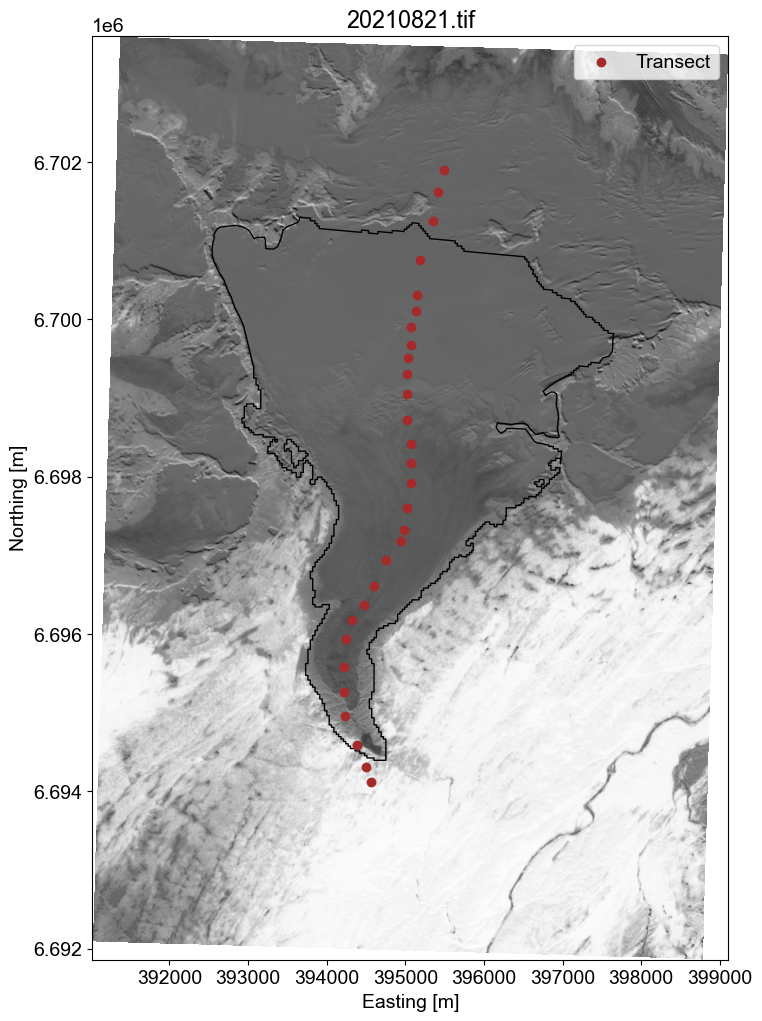

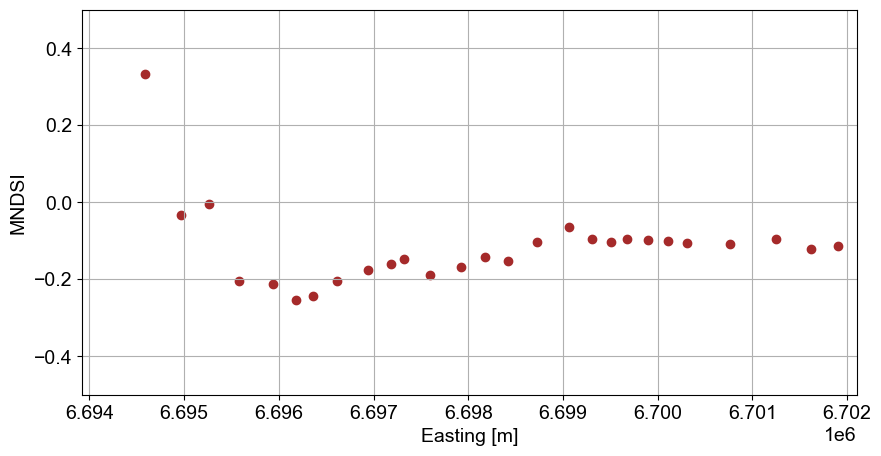

In [24]:
### function to calculate MNDSI
def calculate_mndsi(red,nir):
    return es.normalized_diff(nir, red)

### open image
scalar = 10000 # scalar multiplier used when saving image
im = rio.open(im_name[0])
# read bands
blue = im.read(1) / scalar
green = im.read(2) / scalar
red = im.read(3) / scalar
nir = im.read(4) / scalar
# compute MNDSI
mndsi = calculate_mndsi(red,nir) 

### read in snowline and transect coordinates, extract MNDSI along transect 
## snowline
# extract points from geometry
sl_pts = [i for i in sl.geometry]
sl_x,sl_y = sl_pts[0].coords.xy
sl_coords = np.dstack((sl_x,sl_y)).tolist()
## transect
# extract points from geometry
ts_pts = [i for i in ts.geometry]
ts_x,ts_y = ts_pts[0].coords.xy
ts_coords = np.dstack((ts_x,ts_y)).tolist()
# sample raster values at coordinates
ts_rv = [x for x in im.sample(ts_coords[0])]
# calculate MNDSI at points
ts_mndsi = []
for s in ts_rv:
    ts_mndsi = ts_mndsi + [calculate_mndsi(s[2]/scalar, s[3]/scalar)]

# plot
fig1, ax1 = plt.subplots(1,1,figsize=(12,12))
plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
# MNDSI, snowline, and transect locations
show(mndsi, transform=im.transform, cmap='Greys_r', ax=ax1)
AOI.plot(ax=ax1, facecolor='none', edgecolor='black', label='AOI')
#sl.plot(ax=ax1, linestyle='-', color='cyan', label='Snowline')
ax1.scatter(ts_x, ts_y, color='brown', label='Transect')
ax1.set_title(im_name[0])
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.legend()
# MNDSI values along transect
fig2, ax2 = plt.subplots(1,1, figsize=(10,5))
plt.rcParams.update({'font.size': 14})
ax2.set_xlim(np.min(ts_y)-200, np.max(ts_y)+200)
ax2.scatter(ts_y, ts_mndsi, color='brown', label='Transect')
ax2.set_xlabel('Easting [m]')
ax2.set_ylabel('MNDSI')
ax2.set_ylim(-0.5,0.5)
ax2.grid()
plt.show()

### Identify snow by adjusting thresholds

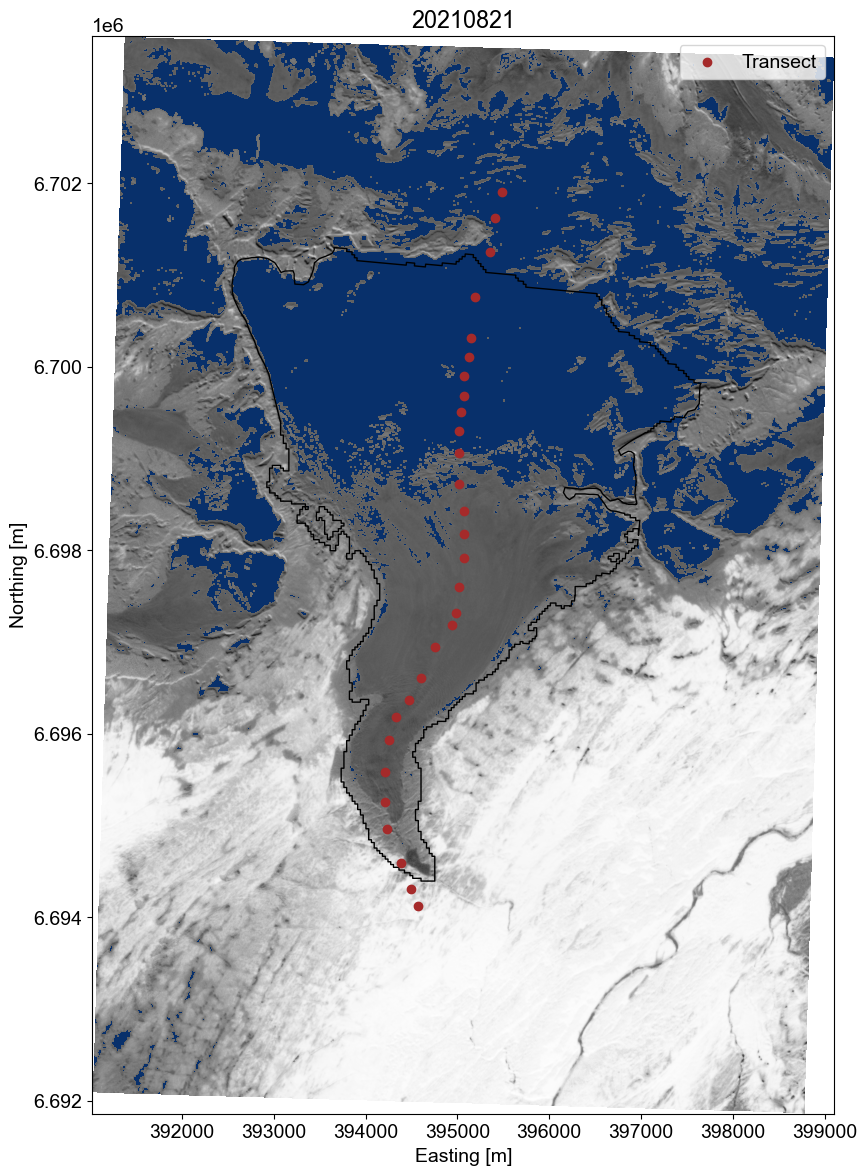

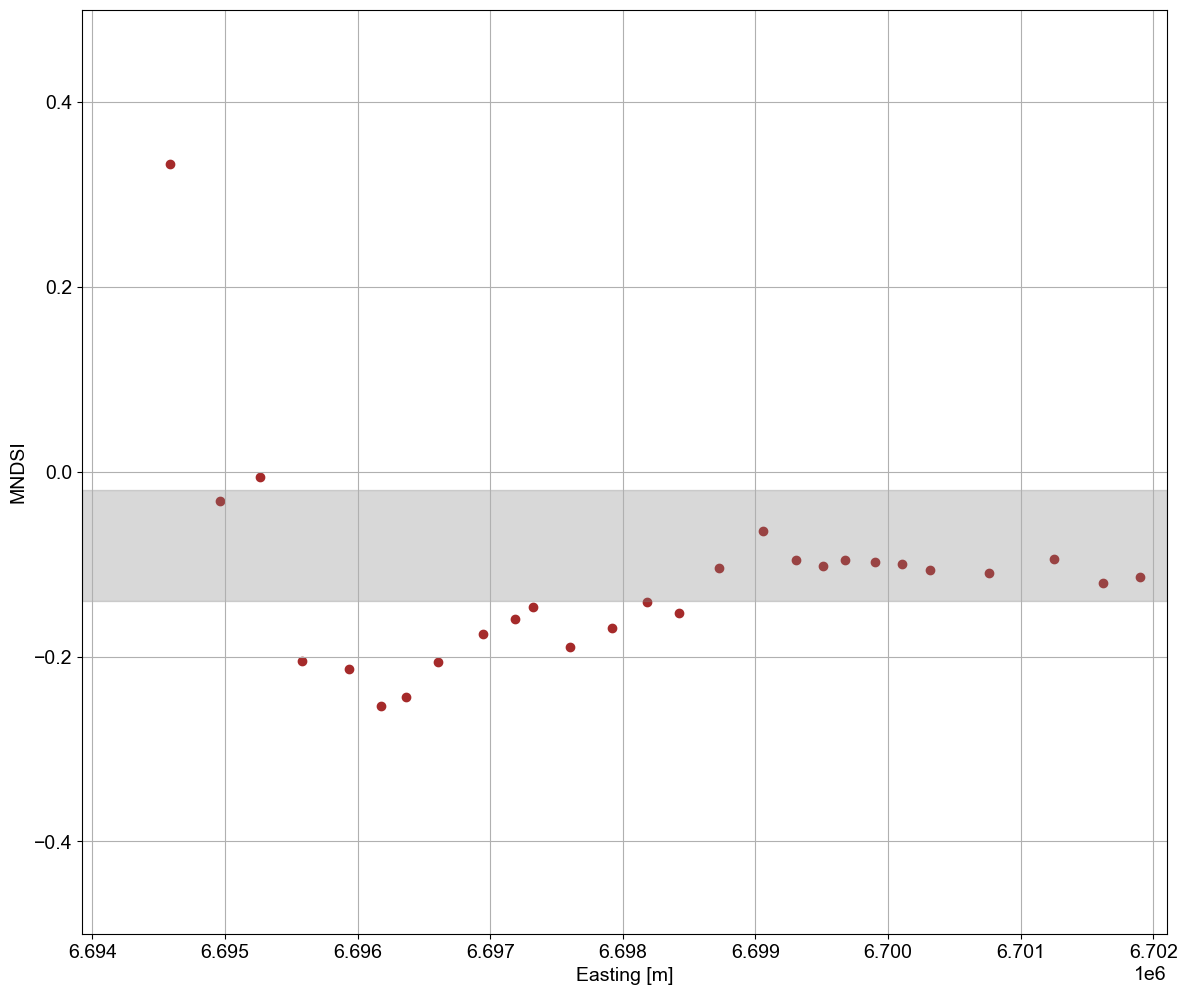

In [28]:
# Determine thresholds
thresh_min = -0.14
thresh_max = -0.02

# threshold MNDSI to determine snow cover
snow = np.where((mndsi>thresh_min) & (mndsi<thresh_max),1,np.nan)

# plot 
fig2, ax1 = plt.subplots(1,1,figsize=(14,14))
plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
# MNDSI, snow, snowline, and transect locations
show(mndsi, transform=im.transform, cmap='Greys_r', ax=ax1)
show(snow, transform=im.transform, cmap='Blues', clim=(0,1), ax=ax1)
AOI.plot(facecolor='none', edgecolor='black', label='AOI', ax=ax1)
#sl.plot(linestyle='-', color='cyan', label='Snowline', ax=ax1)
ax1.scatter(ts_x, ts_y, color='brown', label='Transect')
ax1.set_title(im_name[0][0:8])
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.legend()
# MNDSI values along transect
fig3, ax1 = plt.subplots(1,1, figsize=(14,12))
ax1.set_xlim(np.min(ts_y)-200, np.max(ts_y)+200)
rect=matplotlib.patches.Rectangle((ax1.get_xlim()[0],thresh_min),ax1.get_xlim()[1]-ax1.get_xlim()[0],thresh_max-thresh_min, 
                        fill=True, color="grey", alpha=0.3, label='threshold')
plt.gca().add_patch(rect)
ax1.scatter(ts_y, ts_mndsi, color='brown', label='Transect')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('MNDSI')
ax1.set_ylim(-0.5,0.5)
ax1.grid()
plt.show()